In [1]:
import re
import unicodedata
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM,  Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Prepare Data

In [2]:
df = pd.read_csv("/kaggle/input/language-translation-englishfrench/eng_-french.csv")
df = df.sample(frac=1)
df.head(3)

,English words/sentences,French words/sentences
21700,We've all seen it.,Nous l'avons tous vu.
141398,I'm hungry because I haven't had lunch.,J'ai faim car je n'ai pas déjeuné.
75404,I didn't see Tom yesterday.,Je n'ai pas vu Tom hier.


In [3]:
train_ratio = 0.8
val_ratio = 0.2

train = df.iloc[:int(len(df) * 0.8)]
val = df.iloc[int(len(df) * 0.8):]

assert(len(train) + len(val) == len(df))
len(train), len(val)

(140496, 35125)

In [4]:
# unicode normalization
def normalize_unicode(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# retain punctuation, delete whitespace
def preprocess(s):
    s = normalize_unicode(s)
    s = re.sub(r"([?.!,¿])", r" \1 ", s)
    s = re.sub(r'[" "]+', " ", s)
    s = s.strip()
    return s

# add <sos>, <eos> tags
def tag_sentences(sentences):
    tagged_sentences = map(lambda s: ' '.join(['<sos>', s, '<eos>']), sentences)
    return list(tagged_sentences)

In [5]:
def prepare_data(data, input_tokenizer, output_tokenizer, fit_tokenizer, max_encoding_length, max_decoding_length):
    input_sentences = list(data['French words/sentences'].values)
    output_sentences = list(data['English words/sentences'].values)
    input_sentences_preprocessed = [preprocess(sentence) for sentence in input_sentences]
    output_sentences_preprocessed = [preprocess(sentence) for sentence in output_sentences]
    output_sentences_preprocessed = tag_sentences(output_sentences_preprocessed)
    if fit_tokenizer:
        input_tokenizer.fit_on_texts(input_sentences_preprocessed)
        output_tokenizer.fit_on_texts(output_sentences_preprocessed)
    INPUT_VOCAB_SIZE = len(input_tokenizer.word_index) + 1
    OUTPUT_VOCAB_SIZE = len(output_tokenizer.word_index) + 1
    input_sequences = input_tokenizer.texts_to_sequences(input_sentences_preprocessed)
    output_sequences = output_tokenizer.texts_to_sequences(output_sentences_preprocessed)
    decoder_inputs = [sequence[:-1] for sequence in output_sequences]
    decoder_targets = [sequence[1:] for sequence in output_sequences]
    encoder_inputs = pad_sequences(input_sequences, maxlen=max_encoding_length, padding='post', truncating='post')
    decoder_inputs = pad_sequences(decoder_inputs, maxlen=max_decoding_length, padding='post', truncating='post')
    decoder_targets = pad_sequences(decoder_targets, maxlen=max_decoding_length, padding='post', truncating='post')
    return encoder_inputs, decoder_inputs, decoder_targets, INPUT_VOCAB_SIZE, OUTPUT_VOCAB_SIZE

In [6]:
en_tokenizer = Tokenizer(oov_token='<UNK_EN', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
fr_tokenizer = Tokenizer(oov_token='<UNK_FR>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')

In [7]:
MAX_ENCODING_LENGTH = int(df['English words/sentences'].apply(lambda x: len(x.split())).quantile(0.95))
MAX_DECODING_LENGTH = int(df['French words/sentences'].apply(lambda x: len(x.split())).quantile(0.95)) - 1

In [8]:
encoder_inputs_train, decoder_inputs_train, decoder_targets_train, FR_VOCAB_SIZE, EN_VOCAB_SIZE = prepare_data(train, fr_tokenizer, en_tokenizer, True, MAX_ENCODING_LENGTH, MAX_DECODING_LENGTH)
encoder_inputs_val, decoder_inputs_val, decoder_targets_val, _, _ = prepare_data(val, fr_tokenizer, en_tokenizer, False, MAX_ENCODING_LENGTH, MAX_DECODING_LENGTH)

## Model

In [9]:
encoder_inputs = Input(shape=[None])
encoder_embeddings = Embedding(input_dim=EN_VOCAB_SIZE,
                               output_dim=256,
                               mask_zero=True)(encoder_inputs)
_, state_h, state_c = LSTM(units=1024,
                           return_state=True,
                           return_sequences=False,
                           dropout=0.2)(encoder_embeddings)
encoder_states = [state_h, state_c]

In [10]:
decoder_inputs = Input(shape=[None])
decoder_embeddings = Embedding(input_dim=FR_VOCAB_SIZE,
                               output_dim=256,
                               mask_zero=True)(decoder_inputs)
decoder_lstm, _, _ = LSTM(units=1024,
                           return_state=True,
                           return_sequences=True,
                           dropout=0.2)(decoder_embeddings, initial_state=encoder_states)
decoder_dense = Dense(units=FR_VOCAB_SIZE, 
                      activation='softmax')(decoder_lstm)

In [11]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], 
                       outputs=decoder_dense,
                       name='english-french-translation')

In [12]:
model.summary()

Model: "english-french-translation"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 256)            3460352   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 256)            6929152   ['input_2[0][0]']             
                                                                         

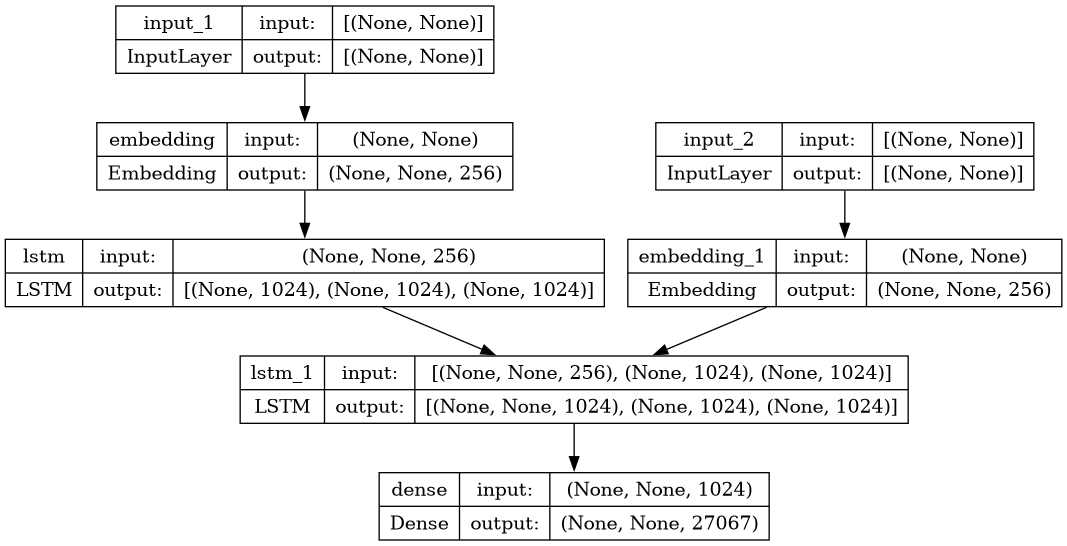

In [13]:
plot_model(model, show_shapes=True)

In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')

In [15]:
callback = EarlyStopping(monitor='val_accuracy', 
                         patience=3,
                         restore_best_weights=True)

In [16]:
history = model.fit([encoder_inputs_train, decoder_inputs_train],
                    decoder_targets_train,
                    validation_data=([encoder_inputs_val, decoder_inputs_val], decoder_targets_val),
                    epochs=20,
                    batch_size=70,
                    callbacks=[callback])


Epoch 1/20
2008/2008 [==============================] - 230s 110ms/step - loss: 3.7281 - accuracy: 0.3775 - val_loss: 2.9447 - val_accuracy: 0.4715
Epoch 2/20
2008/2008 [==============================] - 200s 100ms/step - loss: 2.5063 - accuracy: 0.5261 - val_loss: 2.3069 - val_accuracy: 0.5674
Epoch 3/20
2008/2008 [==============================] - 199s 99ms/step - loss: 1.8823 - accuracy: 0.6131 - val_loss: 1.9333 - val_accuracy: 0.6326
Epoch 4/20
2008/2008 [==============================] - 198s 99ms/step - loss: 1.4545 - accuracy: 0.6803 - val_loss: 1.7437 - val_accuracy: 0.6693
Epoch 5/20
2008/2008 [==============================] - 199s 99ms/step - loss: 1.1572 - accuracy: 0.7320 - val_loss: 1.6083 - val_accuracy: 0.6987
Epoch 6/20
2008/2008 [==============================] - 199s 99ms/step - loss: 0.9064 - accuracy: 0.7811 - val_loss: 1.5268 - val_accuracy: 0.7201
Epoch 7/20
2008/2008 [==============================] - 199s 99ms/step - loss: 0.7237 - accuracy: 0.8200 - val_loss:

In [17]:
model.save('english-french-translation-model')
!zip -r ./english-french-translation-model.zip ./english-french-translation-model

  adding: english-french-translation-model/ (stored 0%)
  adding: english-french-translation-model/variables/ (stored 0%)
  adding: english-french-translation-model/variables/variables.index (deflated 63%)
  adding: english-french-translation-model/variables/variables.data-00000-of-00001 (deflated 14%)
  adding: english-french-translation-model/assets/ (stored 0%)
  adding: english-french-translation-model/saved_model.pb (deflated 90%)
  adding: english-french-translation-model/fingerprint.pb (stored 0%)
  adding: english-french-translation-model/keras_metadata.pb (deflated 90%)
